# Robot Class

In this project, we'll be localizing a robot in a 2D grid world. The basis for simultaneous localization and mapping (SLAM) is to gather information from a robot's sensors and motions over time, and then use information about measurements and motion to re-construct a map of the world.

### Uncertainty

Robot motion and sensors have some uncertainty associated with them. For example, imagine a car driving up hill and down hill; the speedometer reading will likely overestimate the speed of the car going up hill and underestimate the speed of the car going down hill because it cannot perfectly account for gravity. Similarly, we cannot perfectly predict the *motion* of a robot. A robot is likely to slightly overshoot or undershoot a target location.

In this notebook we'll create a robot and move it around a 2D grid world. Before we start analyzing robot motion, let's load in our resources and define the `robot` class. This class initializes the robot's position and adds measures of uncertainty for motion. Then, our task is to define a `sense` function for this robot that allows it to sense landmarks in a given world. 

In [2]:
# import some resources
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [3]:
# the robot class
class robot:
    
    def __init__(self, world_size = 100.0, measurement_range = 30.0,
                 motion_noise = 1.0, measurement_noise = 1.0):
        """
        Creates a robot with the specified parameters and initializes 
        the location (self.x, self.y) to the center of the world.
        """
        self.measurement_noise = 0.0
        self.world_size = world_size
        self.measurement_range = measurement_range
        self.x = world_size / 2.0
        self.y = world_size / 2.0
        self.motion_noise = motion_noise
        self.measurement_noise = measurement_noise
        self.landmarks = []
        self.num_landmarks = 0

    
    def rand(self):
        """
        Returns a positive, random float.
        """
        return random.random() * 2.0 - 1.0


    
    def move(self, dx, dy):
        """
        Attempts to move robot by dx, dy. If outside world boundary, 
        then the move does nothing and instead returns failure.
        """
        x = self.x + dx + self.rand() * self.motion_noise
        y = self.y + dy + self.rand() * self.motion_noise

        if x < 0.0 or x > self.world_size or y < 0.0 or y > self.world_size:
            return False
        else:
            self.x = x
            self.y = y
            return True
    
    
    def make_landmarks(self, num_landmarks):
        """
        Make random landmarks located in the world.
        """
        self.landmarks = []
        for i in range(num_landmarks):
            self.landmarks.append([round(random.random() * self.world_size),
                                   round(random.random() * self.world_size)])
        self.num_landmarks = num_landmarks
    
    
    def __repr__(self):
        """
        Called when print(robot) is called; prints the robot's location.
        """
        return 'Robot: [x=%.5f y=%.5f]'  % (self.x, self.y)


## Define a world and a robot

Next, let's instantiate a robot object. As you can see in `__init__` above, the robot class takes in a number of parameters including a world size and some values that indicate the sensing and movement capabilities of the robot.

In the next example, we define a small 10x10 square world, a measurement range that is half that of the world and small values for motion and measurement noise. These values will typically be about 10 times larger, but we just want to demonstrate this behavior on a small scale. 

In [4]:
world_size         = 10.0    # size of world (square)
measurement_range  = 5.0     # range at which we can sense landmarks
motion_noise       = 0.2      # noise in robot motion
measurement_noise  = 0.2      # noise in the measurements

# instantiate a robot, r
r = robot(world_size, measurement_range, motion_noise, measurement_noise)

# print out the location of r
print(r)

Robot: [x=5.00000 y=5.00000]


## Visualizing the World

In the given example, we can see that the robot is in the middle of the 10x10 world at (x, y) = (5.0, 5.0), which is exactly what we expect. However, it's kind of hard to imagine this robot in the center of a world, without visualizing the grid itself, and so in the next cell we provide a helper visualization function, `display_world`, that will display a grid world in a plot and draw a red `o` at the location of our robot, `r`. The details of how this function wors can be found in the `helpers.py` file in the home directory.

Robot: [x=5.00000 y=5.00000]


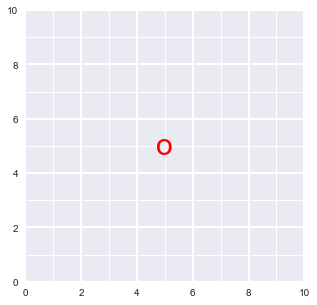

In [5]:
# import helper function
from helpers import display_world

# define figure size
plt.rcParams["figure.figsize"] = (5,5)

# call display_world and display the robot in it's grid world
print(r)
display_world(int(world_size), [r.x, r.y])

## Movement

Now you can really picture where the robot is in the world. Next, let's call the robot's `move` function. We'll ask it to move some distance `(dx, dy)` and we'll see that this motion is not perfect by the placement of our robot `o` and by the printed out position of `r`. When running this cell multiple times, we can see how the robot moves and how the uncertainty in robot motion accumulates over multiple movements. We can also notice that the robot stops once a wall has been reached. 

Robot: [x=5.97955 y=6.97497]


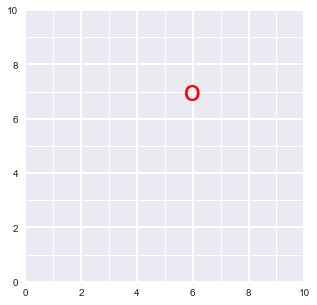

In [6]:
# choose values of dx and dy (negative works, too)
dx = 1
dy = 2
r.move(dx, dy)

# print out the exact location
print(r)

# display the world after movement, not that this is the same call as before
# the robot tracks its own movement
display_world(int(world_size), [r.x, r.y])

## Landmarks

Next, let's create landmarks, which are measurable features in the map. Landmarks can be thought of as things like notable buildings, or something smaller such as a tree, rock, or other feature.

The robot class has a function `make_landmarks` which randomly generates locations for the number of specified landmarks. We have to pass these locations as a third argument to the `display_world` function and the list of landmark locations is accessed similar to how we find the robot position `r.landmarks`. 

Each landmark is displayed as a purple `x` in the grid world, and we also print out the exact `[x, y]` locations of these landmarks at the end of this cell.

Robot: [x=5.97955 y=6.97497]


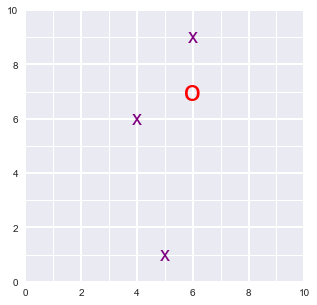

Landmark locations [x,y]:  [[4, 6], [6, 9], [5, 1]]


In [7]:
# create any number of landmarks
num_landmarks = 3
r.make_landmarks(num_landmarks)

# print out our robot's exact location
print(r)

# display the world including these landmarks
display_world(int(world_size), [r.x, r.y], r.landmarks)

# print the locations of the landmarks
print('Landmark locations [x,y]: ', r.landmarks)

## Sense

Once we have some landmarks to sense, we need to be able to tell our robot to *try* to sense how far they are away from it. The `sense` function uses only internal class parameters and returns a list of the the measured/sensed x and y distances to the landmarks it senses within the specified `measurement_range`. 

The measurements have the format, `[i, dx, dy]` where `i` is the landmark index (0, 1, 2, ...) and `dx` and `dy` are the measured distance between the robot's location (x, y) and the landmark's location (x, y). This distance will not be perfect since our sense function has some associated `measurement noise`.

In [8]:
from math import *

class robot:
    
    def __init__(self, world_size = 100.0, measurement_range = 30.0,
                 motion_noise = 1.0, measurement_noise = 1.0):
        """
        Creates a robot with the specified parameters and initializes 
        the location (self.x, self.y) to the center of the world.
        """
        self.measurement_noise = 0.0
        self.world_size = world_size
        self.measurement_range = measurement_range
        self.x = world_size / 2.0
        self.y = world_size / 2.0
        self.motion_noise = motion_noise
        self.measurement_noise = measurement_noise
        self.landmarks = []
        self.num_landmarks = 0

    
    def rand(self):
        """
        Returns a positive, random float.
        """
        return random.random() * 2.0 - 1.0


    def move(self, dx, dy):
        """
        Attempts to move robot by dx, dy. If outside world boundary, 
        then the move does nothing and instead returns failure.
        """
        x = self.x + dx + self.rand() * self.motion_noise
        y = self.y + dy + self.rand() * self.motion_noise

        if x < 0.0 or x > self.world_size or y < 0.0 or y > self.world_size:
            return False
        else:
            self.x = x
            self.y = y
            return True
    

    
    def sense(self):
        """ 
        This function does not take in any parameters, instead it references internal variables
        (such as self.landamrks) to measure the distance between the robot and any landmarks
        that the robot can see (that are within its measurement range). The function accounts 
        for measurement_noise and measurement_range.
        
        Returns a list of landmark indices, and the measured distances (dx, dy) between the robot's 
        position and said landmarks. One item in the list will be in the form: [landmark_index, dx, dy].
        """
           
           
        measurements = []
        
        ## For each landmark
        ## 1. compute dx and dy, the distances between the robot and the landmark
        ## 2. account for measurement noise by *adding* a noise component to dx and dy
        ##    - The noise component should be a random value between [-1.0, 1.0)*measurement_noise        
        ## 3. If either of the distances, dx or dy, fall outside of the internal var, measurement_range
        ##    then we cannot record them; if they do fall in the range, then add them to the measurements list
        ##    as list.append([index, dx, dy]), this format is important for data creation done later
        
        for i, lk in enumerate(self.landmarks):
            dx = lk[0] - self.x
            dy = lk[1] - self.y
            dx += self.rand()*self.measurement_noise
            dy += self.rand()*self.measurement_noise
            d = sqrt(dx*dx + dy*dy)
            
            if d <= self.measurement_range:
                measurements += [[i, dx, dy]]
                #measurements += [(i, dx, dy)]
        
        return measurements

        
    def make_landmarks(self, num_landmarks):
        """
        Make random landmarks located in the world.
        """
        self.landmarks = []
        for i in range(num_landmarks):
            self.landmarks.append([round(random.random() * self.world_size),
                                   round(random.random() * self.world_size)])
        self.num_landmarks = num_landmarks
    
        
    def __repr__(self):
        """
        Called when print(robot) is called; prints the robot's location.
        """
        return 'Robot: [x=%.5f y=%.5f]'  % (self.x, self.y)


Robot: [x=5.00000 y=5.00000]
Landmark locations [x,y]:  [[2, 0], [1, 2], [2, 6]]
[[1, -3.8924030216630783, -3.109868985402982], [2, -3.088033264786316, 1.1279195005645386]]


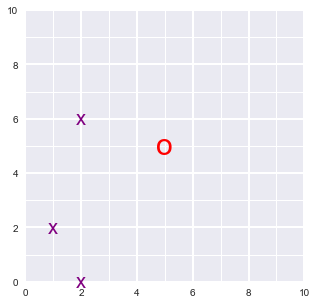

In [9]:
# instantiate a robot, r
r = robot(world_size, measurement_range, motion_noise, measurement_noise)

# create any number of landmarks
num_landmarks = 3
r.make_landmarks(num_landmarks)

# print out our robot's exact location
print(r)

# print the locations of the landmarks
print('Landmark locations [x,y]: ', r.landmarks)

# try to sense any surrounding landmarks
measurements = r.sense()

# this will print out an empty list if `sense` has not been implemented
print(measurements)

# display the world including these landmarks
display_world(int(world_size), [r.x, r.y], r.landmarks)


---
## Data

To perform SLAM, we'll collect a series of robot sensor measurements and motions, in that order, over a defined period of time. Then we'll use only this data to reconstruct the map of the world with the robot and landmar locations. SLAM can be thought of as peforming what we've done in this notebook, only backwards. 

Movements and sensor measurements are listed in a structure called `data` in a specific order, which will be useful to form constraint matrices and vectors. It is constructed over a series of time steps as follows:

In [10]:
data = []

# after a robot first senses, then moves (one time step)
# that data is appended like so:
data.append([measurements, [dx, dy]])

# for our example movement and measurement
print(data)

[[[[1, -3.8924030216630783, -3.109868985402982], [2, -3.088033264786316, 1.1279195005645386]], [1, 2]]]


In [11]:
# in this example, we have only created one time step (0)
time_step = 0

# so you can access robot measurements:
print('Measurements: ', data[time_step][0])

# and its motion for a given time step:
print('Motion: ', data[time_step][1])

Measurements:  [[1, -3.8924030216630783, -3.109868985402982], [2, -3.088033264786316, 1.1279195005645386]]
Motion:  [1, 2]
